# Palermo Forecast
### Procedures:
- Web scraping
- Cleaning data
- Data plot
- Machine Learning
- Tunning ML

## 1. Packages

In [1]:
import requests
import pandas as pd
import io
import os
import glob
from detect_delimiter import detect
from datetime import date


## 2. Web scraping 

The following code will extract the data in cvs format from the website "https://www.ilmeteo.it/portale/archivio-meteo/Palermo" from January 1973 to actual data. All cvs files will be extracted and stored locally. 

In [2]:
months=['Gennaio','Febbraio','Marzo','Aprile','Maggio','Giugno','Luglio','Agosto','Settembre','Ottobre','Novembre','Dicembre']
today = date.today()
for year in range(1973,(today.year-1)):
    for month in months:
        url="https://www.ilmeteo.it/portale/archivio-meteo/Palermo/"+str(year)+"/"+month+"?format=csv"
        response = requests.get(url, stream=True).content
        df_response=pd.read_csv(io.StringIO(response.decode('utf-8')), sep=';')
        df_response.to_csv('Palermo-'+str(year)+'-'+month+'.csv')
        

In [3]:
monthsY=months[0:today.month-1]
year= today.year
for month in monthsY:
    url="https://www.ilmeteo.it/portale/archivio-meteo/Palermo/"+str(year)+"/"+month+"?format=csv"
    response = requests.get(url, stream=True).content
    df_response=pd.read_csv(io.StringIO(response.decode('utf-8')), sep=';')
    df_response.to_csv('Palermo-'+str(year)+'-'+month+'.csv')

  

## 3. Mearging data
Find the name of all csv files and combine the information into a single data frame. I also included the files from 2023

In [4]:
csv_files = glob.glob('*.{}'.format('csv'))


['Palermo-1973-Agosto.csv', 'Palermo-1973-Aprile.csv', 'Palermo-1973-Dicembre.csv', 'Palermo-1973-Febbraio.csv', 'Palermo-1973-Gennaio.csv', 'Palermo-1973-Giugno.csv', 'Palermo-1973-Luglio.csv', 'Palermo-1973-Maggio.csv', 'Palermo-1973-Marzo.csv', 'Palermo-1973-Novembre.csv', 'Palermo-1973-Ottobre.csv', 'Palermo-1973-Settembre.csv', 'Palermo-1974-Agosto.csv', 'Palermo-1974-Aprile.csv', 'Palermo-1974-Dicembre.csv', 'Palermo-1974-Febbraio.csv', 'Palermo-1974-Gennaio.csv', 'Palermo-1974-Giugno.csv', 'Palermo-1974-Luglio.csv', 'Palermo-1974-Maggio.csv', 'Palermo-1974-Marzo.csv', 'Palermo-1974-Novembre.csv', 'Palermo-1974-Ottobre.csv', 'Palermo-1974-Settembre.csv', 'Palermo-1975-Agosto.csv', 'Palermo-1975-Aprile.csv', 'Palermo-1975-Dicembre.csv', 'Palermo-1975-Febbraio.csv', 'Palermo-1975-Gennaio.csv', 'Palermo-1975-Giugno.csv', 'Palermo-1975-Luglio.csv', 'Palermo-1975-Maggio.csv', 'Palermo-1975-Marzo.csv', 'Palermo-1975-Novembre.csv', 'Palermo-1975-Ottobre.csv', 'Palermo-1975-Settembre.csv

In [5]:
df_all= pd.DataFrame()

for file in csv_files:
    f=open(file)
    firstline=f.readline()
    delimeter= detect(firstline)
    df_temp= pd.read_csv(file, sep=delimeter, index_col='DATA', decimal=',')
    df_all= pd.concat([df_all,df_temp])
    
print(df_all)

           Unnamed: 0 LOCALITA TMEDIA °C TMIN °C TMAX °C PUNTORUGIADA °C  \
DATA                                                                       
1/8/1973          0.0  Palermo      25.1      22      28            20.9   
2/8/1973          1.0  Palermo      26.8      24      30            21.5   
3/8/1973          2.0  Palermo      25.1      23      27            21.6   
4/8/1973          3.0  Palermo      24.9      23      27            21.6   
5/8/1973          4.0  Palermo      25.3      23      27            21.7   
...               ...      ...       ...     ...     ...             ...   
26/9/2023        25.0  Palermo        22      18      25              17   
27/9/2023        26.0  Palermo        24      21      25              19   
28/9/2023        27.0  Palermo        23      20      25              18   
29/9/2023        28.0  Palermo        23      20      25              18   
30/9/2023        29.0  Palermo        23      20      25              18   

          U

## 4. Cleaning data

In [6]:
weather= df_all.copy()
weather.apply(pd.isnull).sum()

Unnamed: 0            1096
LOCALITA                 0
TMEDIA °C               42
TMIN °C                 42
TMAX °C                 42
PUNTORUGIADA °C         42
UMIDITA %               42
VISIBILITA km           42
VENTOMEDIA km/h         42
VENTOMAX km/h           42
RAFFICA km/h            42
PRESSIONESLM mb         42
PRESSIONEMEDIA mb       42
PIOGGIA mm              42
FENOMENI             12843
dtype: int64

In [7]:
core_weather=weather[['TMEDIA °C','TMIN °C','TMAX °C','PIOGGIA mm']].copy()
core_weather.index= pd.to_datetime(core_weather.index,format='%d/%m/%Y')
core_weather[pd.isnull(core_weather['TMEDIA °C'])]
core_weather=core_weather.fillna(method='ffill')

core_weather.index=pd.to_datetime(core_weather.index)
core_weather['TMEDIA °C']=pd.to_numeric(core_weather['TMEDIA °C'])
core_weather['TMIN °C']=pd.to_numeric(core_weather['TMIN °C'])
core_weather['TMAX °C']=pd.to_numeric(core_weather['TMAX °C'])
core_weather['PIOGGIA mm']=pd.to_numeric(core_weather['PIOGGIA mm'])

## 5. Data analysis

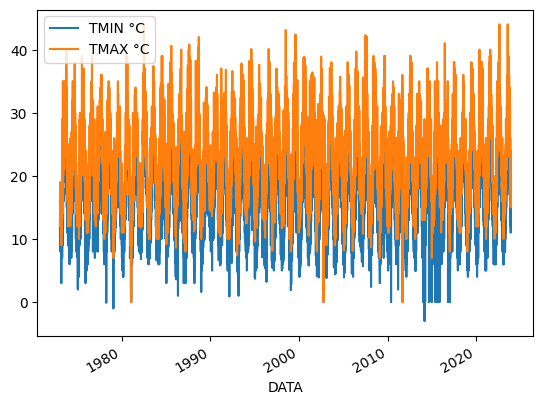

In [8]:
core_weather[['TMIN °C','TMAX °C']].plot()
core_weather.index.year.value_counts().sort_index()

core_weather["target"]= core_weather.shift(-1)['TMEDIA °C']
core_weather= core_weather.iloc[:-1,:].copy()

## 6. Machine Learning

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

def create_predictions(predictors, core_weather, reg):
    train = core_weather.loc[:"2022-12-31"]
    test = core_weather.loc["2023-01-01":]
    reg.fit(train[predictors], train["target"])
    Ridge(alpha=0.1)
    predictions = reg.predict(test[predictors])
    error= mean_absolute_error(test["target"], predictions)
    combined= pd.concat([test["target"],pd.Series(predictions,index=test.index)],axis=1)
    combined.columns=["actual","predictions"]
    return error, combined


reg= Ridge(alpha=.1)

predictors = ['TMEDIA °C','TMIN °C','TMAX °C','PIOGGIA mm']

error, combined = create_predictions(predictors, core_weather, reg)
print(error)

1.2875482220789007


## 7. Tunning ML with extra data

In [10]:
core_weather["month max"]= core_weather['TMEDIA °C'].rolling(30).mean()
core_weather= core_weather.iloc[30:,:].copy()
core_weather["min_max"]= core_weather['TMIN °C']/ core_weather['TMAX °C']
core_weather['monthly_avg']= core_weather['TMEDIA °C'].groupby(core_weather.index.month,group_keys=False).apply(lambda x: x.expanding(1).mean())
predictors=   ['TMEDIA °C','TMIN °C','TMAX °C','PIOGGIA mm','month max','monthly_avg']
error, combined = create_predictions(predictors, core_weather, reg)
print(error)

1.2140319071829813


## 8. Variables analysis

In [11]:
reg.coef_

core_weather.corr()["target"]
combined["diff"]=(combined["actual"]-combined["predictions"]).abs()

combined.sort_values("diff",ascending=False).head()


,actual,predictions,diff
DATA,,,
2023-07-31,18.0,26.560820,8.560820
2023-04-30,11.0,18.696644,7.696644
2023-05-31,12.0,19.584784,7.584784
2023-07-23,36.0,28.547939,7.452061
2023-01-31,20.0,13.005088,6.994912
